<a href="https://colab.research.google.com/github/SteFanIst/Matlab-/blob/master/datadis_api_Stelios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Using DATADIS API to get the hourly electric consumption data at a Region/municipality/ZIP resolution in Spain**


## Author: Raúl Sáez



---


---





**TO DO LIST:**

*   <del>Aggregate results by day (sum up all hours) -> Pandas </del>
*   <del>Allow search and analysis in the loop for various days </del>
*   Find and quantify the gaps in the data
*   Improve visualization of data -> geoPandas
*   <del>Add municipalities (Tarragona) layer</del>
*   <del>Add Postal Code layer</del>
*   <del> Fix random disconnection from the API when running long queries </del>
*   Add a function to take into account the days we change the hour (specific days change every year)
*   Add the "num de contratos" variable in the output
*   **Create a logical data structure when several municipalities/postal codes are extracted**
*   Make some analysis


**PROBLEMS DETECTED:**

*  Ceuta and Melilla present serious gaps in the data
*  DATADIS not always present lower values than REE (maybe related with data post 06/20?)
*  <del>DATADIS API disconnects from time to time </del> (fixed) -> timeout per query as 60s

**NOTES:**

*  DATADIS data starts at 01/03/2018
*  In REE Database, final data (non-provisonal) arrives until 06/20. (updated 04/10/21)  
*  Link to municipalities database file: https://rovira.sharepoint.com/:x:/s/GR_Suscape/EVZiquz_6FlKlyIp8ydysxkBPvVOfyaXQZwlJ2QnLLZIig?e=4qJPiD

*  Link to Postal Code database file: https://rovira.sharepoint.com/:x:/r/sites/GR_Suscape/Documentos%20compartidos/General/Ra%C3%BAl/DATADIS%20API/postalCodes.csv?d=wd6ab796d40f0465497bd1e2b5ff9d278&csf=1&web=1&e=vaJsog




---







In [1]:
## AVOID THIS CELL, IT IS JUST TO IMPORT THE PERSONAL GOOGLE DRIVE FOLDER

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Getting raw data from the *API*





### 1.1 Defining the functions to get some data from the API

In [35]:
!pip install datetime

     |████████████████████████████████| 60 kB 2.8 MB/s 
     |████████████████████████████████| 251 kB 8.6 MB/s 


In [36]:
# Importing a basic python library to communicate with the API and to make the analysis

import requests #for DATADIS API communication
import json #to deal with the data
import pandas as pd #to deal with the data
from urllib.request import urlopen #for REE API communication
import matplotlib.pyplot as plt  #to plot datamitjana
import datetime
import csv
#import time #to sleep

In [4]:
# THE CLASS authClass TO DEFINE ATTRIBUTES IN SOME OBJECTS LATER

class authClass(object):
   def __init__(self):
       self.status = None
       self.output = None

In [5]:
# THE CLASS inputQueryClass TO DEFINE ATTRIBUTES IN THE SEARCH QUERY OBJECT LATER

class inputQueryClass(object):
   def __init__(self):
       self.startDate             = None
       self.endDate               = None
       self.page                  = '0'
       self.pageSize              = '100'
       self.measurePointType      = '' 
       self.community             = ''
       self.distributor           = ''
       self.fare                  = ''
       self.provinceMunicipality  = ''
       self.postalCode            = ''
       self.economicSector        = ''
       self.tension               = ''
       self.timeDiscrimination    = ''

In [6]:
# # THE CLASS inputQueryClass TO DEFINE ATTRIBUTES IN THE SEARCH QUERY OBJECT LATER

# class inputQueryClass(object):
#    def __init__(self):
#        self.startDate = None
#        self.endDate = None
#        self.page = None
#        self.pageSize = None
#        self.measurePointType = None 
#        self.community = None
#        self.distributor = None
#        self.fare = None
#        self.provinceMunicipality = None
#        self.postalCode = None
#        self.economicSector = None
#        self.tension = None
#        self.timeDiscrimination = None

In [7]:
# A FUNCTION TO CHECK IF AUTHENTIFICATION SUCCEED

def authentificationStatus(response):
  if response.status_code == 200:             
    statusMessage="Authentification Succeed"
  else: #if status_code is not 200, we have a problem. Check error code.
    statusMessage="Invalid Authentification. Error code: " + str(response.status_code)
    print(statusMessage)

In [8]:
# A FUNCTION TO CODIFICATE DATE FORMATS FROM PLAIN TEXT TO HTML DATADIS

def inputDate(dia,mes,any):
  return any+"%2F"+mes+"%2F"+dia

In [9]:
# A FUNCTION TO CODIFICATE DATE FORMATS FROM PLAIN TEXT TO STRING YYYY-MM-dd

def inputDateSTD(dia,mes,any):
  return any+"-"+mes+"-"+dia

In [10]:
# A FUNCTION TO CODIFICATE DATE FORMATS FROM PLAIN TEXT TO STRING YYYY-MM-dd

def transfDate(str):
  return str[0:4]+"%2F"+str[5:7]+"%2F"+str[8:10]

In [11]:
# A FUNCTION TO GET THE TOKEN IN DATADIS.ES USING URV CREDENTIALS (SPECIFIC PERMISSIONS WHERE GIVEN IN ORDER TO GET ACCESS TO THE PUBLIC API)

def getToken(user,password):
  #user Q9350003A
  #pass D%40tadis2000 (html encoded, the original pass is: D@tadis2000)

  # Define token object as authClass() object
  _token = authClass()

  # Calling the API URL using the 'user' and 'password' provided
  urlToken = "https://datadis.es/nikola-auth/tokens/login?username="+user+"&password="+password
  response = requests.post(urlToken)

  # Defining attributes for the 'token' object
  _token.status = authentificationStatus(response)
  _token.output = response.text # That's the token itself
  
  return _token

In [34]:
# A FUNCTION TO AUTHENTIFICATE INSIDE THE PUBLIC API USING THE TOKEN IN ORDER TO ALLOW QUERIES

from requests.structures import CaseInsensitiveDict

def getData(tokenData,inputQuery):

  # Defining the URL including all the parametersCREATING THE HTTPS REQUEST INCLUDING THE PARAMETERS :
  query = "https://datadis.es/api-public/api-search?startDate="+inputQuery.startDate+"&endDate="+inputQuery.startDate+"&page="+inputQuery.page+"&pageSize="+inputQuery.pageSize+"&measurePointType="+inputQuery.measurePointType+"&community="+inputQuery.community+"&distributor="+inputQuery.distributor+"&fare="+inputQuery.fare+"&provinceMunicipality="+inputQuery.provinceMunicipality+"&postalCode="+inputQuery.postalCode+"&economicSector="+inputQuery.economicSector+"&tension="+inputQuery.tension+"&timeDiscrimination="+inputQuery.timeDiscrimination+"&sort="

  # Define query response object as authClass() object
  _data = authClass()

  # Using the "headers" authentification method (common for most of the APIs around)
  headers = CaseInsensitiveDict()
  headers["Accept"] = "application/json"
  headers["Authorization"] = "Bearer " + tokenData
  
  # This is to avoid random disconnections during long queries
  try:
    resp = requests.get(query, headers=headers, timeout=120)
    
  except:
    resp = requests.get(query, headers=headers, timeout=120)
  
  #resp = hopeitworks(query,headers)

  # Defining attributes to the 'data' object
  _data.status = authentificationStatus(resp)
  _data.output = resp.text # That's the query response itself, so the data we want
  #print(_data.output)
  
  return _data

In [13]:
# CONVERTING DATA TO DICT (key, value) -> (hora del día, KWh)

####### TO DO: MODIFY TO INCLUDE THE NUMBER OF CONTRACTS PER QUERY ########


def outputToJson(string):
  
  ##debuging
  #global algo2
  #algo2 = string

  if len(string) > 4:

    jData = json.loads(string)
    value = []
    key = []
  
    for line in jData[0]:

      if line.startswith('sumContracts'):
        value.append(jData[0][line])
        key.append('sumContracts')
      elif line.startswith('mi'):
        value.append(int(jData[0][line]))
        key.append(line[2:])
  
  #To fill gaps. When no data for specific query, fill tmitjanahe consumption data with '0'.
  else:
    
    value = ['0'] * 25
    key = ['sumContracts', ("{:01d}".format(x) for x in range(1,25))]
    #key = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24']
    #key = []
    #for i in range(1,25):
    #  key.append(str(i))
  
  outputZip = zip(key,value)
  outputDict = dict(outputZip)

  return outputDict

In [14]:
# # CONVERTING DATA TO DICT (key, value) -> (hora del día, KWh)

# ####### TO DO: MODIFY TO INCLUDE THE NUMBER OF CONTRACTS PER QUERY ########


# def outputToJson(string):
  
#   ##debuging
#   #global algo2
#   #algo2 = string

#   if len(string) > 4:

#     jData = json.loads(string)
#     value = []
#     key = []
  
#     for line in jData[0]:
#       if line.startswith('mi'):
#         value.append(int(jData[0][line]))
#         key.append(line[2:])
  
#   #To fill gaps
#   else:

#     value = ['0'] * 24
#     key = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24']
#     #key = []
#     #for i in range(1,25):
#     #  key.append(str(i))
  
#   outputZip = zip(key,value)
#   outputDict = dict(outputZip)

#   return outputDict


In [15]:
# FUNCTION TO CREATE A LIST FROM THE _startDate AND _endDate VARIABLES DEFINED

def dayList(_startDate,_endDate):
  # Set a Panda Series with DATES
  dateSeries = pd.Series(pd.date_range(start=inputDateSTD(_startDate[0],_startDate[1],_startDate[2]),end=inputDateSTD(_endDate[0],_endDate[1],_endDate[2]), freq='D'))

  # Transform the series into list of strings
  dateList = []
  for i in dateSeries:
    dateList.append(str(i)[:-9])

  return dateList

In [16]:
#Fix some problems related with the format of the region number
def fixRegion(ccaa):
  
  if len(str(ccaa))==1:
    reg = "0"+str(ccaa)
  else:
    reg = str(ccaa)

  return reg

In [17]:
def theFunction(_startDate,_endDate,regions,prov,sector,municp=False,postal=False):

  global inputQuery
  inputQuery = inputQueryClass()

  #Set the query attributes at 0
  #inputQuery = inputQueryClass()

  #Defining the attribute 'economicSector' in query
  inputQuery.economicSector = str(sector)


  #Statement that breaks the function if municipalities and postal codes are both true
  if municp and postal:
    print("Municipalities and Postal Codes queries must be independent, choose just one")
    return None

  else:

    #We create a dict that we will fill later
    data = {}


    #CASE 1: If there's a province defined in the query:
    if prov:

      
      #Important to define just one region when municipalities/CP are the scope
      inputQuery.community=fixRegion(regions[0])
      
      #Getting Municipalities and postal codes of the province from the database
      pdProvince = geoProv(prov)
      #print(pdProvince)

      #CASE 1: MUNICIPALITIES WITHIN A PROVINCE
      #If municp is True, obtain data for the municipalities
      if municp:
        
        #List of municipalities within the province defined
        listMun = lstMN(pdProvince)

        #For each municipality in the list:
        for codeMun in listMun:

          #line=pdProvince.loc[pdProvince['COD_MUN'] == codeMun]
          #if len(line['NAME_MUN']) > 1:
          #  print(str(line['NAME_MUN'][0]))#Debugging
          #else:
          #  print(str(line['NAME_MUN']))
          
          print('Municipality ', codeMun)

          #Define the query with the municipality:
          inputQuery.provinceMunicipality = str(codeMun)

          #Perform the query for the specific Municipality at a given date
          _data = dailyData(_startDate,_endDate)
          data[int(codeMun)] = _data

      #CASE 2: POSTAL CODES WITHIN A PROVINCE
      elif postal:

        #List of postal codes within the province defined
        listPC = lstPC(pdProvince)

        #For each postal code in the list:
        for codePC in listPC:

          #Define the query with the postal code:
          inputQuery.postalCode = str(codePC)

          print('Postal Code: ', codePC)#Debugging

          #Perform the query for the specific Postal Code at a given date
          _data = dailyData(_startDate,_endDate)
          data[int(codePC)] = _data

      #CASE 3: PROVINCE
      else:

        print('Whole province: ', prov)
        #Define the query with the Province:
        inputQuery.provinceMunicipality = prov

        #Perform the query for the specific Province at a given date
        _data = dailyData(_startDate,_endDate)
        data = _data

    #CASE 4: REGION (CCAA)
    else:
      
      if len(regions) == 1:
        print('Whole region: ', regions[0])

      
      #For each region:
      for ccaa in regions:

        if len(regions) > 1:
          print('Region: ', ccaa)

        #This line is to remove previous queries
        inputQuery.provinceMunicipality = ''

        #Fix some problems related with the format
        if len(str(ccaa))==1:
          reg = "0"+str(ccaa)
        else:
          reg = str(ccaa)

        #Define the query with the region:
        inputQuery.community=reg

        #Perform the query for the specific region at a given date
        _data = dailyData(_startDate,_endDate)
        data[int(ccaa)] = _data
        print(_data) #debuggig
        
        

  return data



In [18]:
def dailyData(_startDate,_endDate):

  #Something to start
  something = []
  
  #Renew token to avoid possible restrictions
  token = getToken(user,password)

  #A list with all days in the interval
  days = dayList(_startDate,_endDate)

  #Iterations for N days
  for day in days:

    print(day)#debugging porpuses.

    #We define the parameters of the API query regarding starting and ending date (one day per query)
    inputQuery.startDate = transfDate(day)
    inputQuery.endDate = inputQuery.startDate

    #Function to obtain data given an input query
    query = getData(token.output,inputQuery)
    
    #print(inputQuery.__dict__) ###### RUN TO CHECK THAT THE QUERY CORRESPOND WITH THE PARAMETERS DEFINED

    #To Json
    outputDict = outputToJson(query.output)

    something.append(outputDict)

  # Convert it to pandas
  outputPandas = pd.DataFrame(something).transpose().set_axis(days, axis=1)
  #print(outputPandas)#Debugging
  
  #Return only the first 24 rows
  return outputPandas.iloc[:-1 , :]

### 1.2 Defining the functions to mix the electrical consumption data with spanish geographical data, in order to enable the Municipality/Postal Code resolution in API Queries




In [19]:
#FUNCTION THAT RETURNS A LIST OF POSTAL CODES AND ITS GEOMETRY AND MUNICIPALITIES IN A GIVEN PROVINCE

def geoProv(prov):

  # Creating a list with all the Postal Codes of a Province TO OBTAIN THE NAMES OF THE MUNICIPALITIES FROM THE FILE 'postalCodes.CSV'
  postalPath = "/content/drive/MyDrive/postalCodes.csv"
  nameDf = pd.read_csv(postalPath,converters={'codigo_postal':str})

  #renaming the column 'municipio_id' to merge it with our geodata
  nameDf.rename(columns={"municipio_id": "COD_MUN", 'codigo_postal':'COD_POSTAL','nombre':'NAME'}, inplace=True)

  postalPath = "/content/drive/MyDrive/geoDataAll3.csv"
  postalDf = pd.read_csv(postalPath,usecols=['COD_POSTAL','COD_MUN','geometry'],converters={'COD_POSTAL':str})
  
  # MERGING BOTH DATAFRAMES TO GET THE NAME
  temp = pd.merge(postalDf,nameDf, on='COD_POSTAL')
  data = pd.DataFrame()
  data = temp[['COD_POSTAL','COD_MUN_y','NAME','geometry']]
  data = data.rename(columns={"COD_MUN_y": "COD_MUN", 'NAME':'NAME_MUN'})

  # A FUNCTION TO SELECT JUST ONE PROVINCE FROM THE GEODATA
  pdProvince = data.loc[data['COD_POSTAL'].str.startswith(str(prov))].reset_index(drop=True)
  return pdProvince


In [20]:
#Trying to get latitud and longitude from the geometry vector data in geoDataAll

def geoData():

  # Creating a list with all the Postal Codes of a Province TO OBTAIN THE NAMES OF THE MUNICIPALITIES FROM THE FILE 'postalCodes.CSV'
  postalPath = "/content/drive/MyDrive/postalCodes.csv"
  nameDf = pd.read_csv(postalPath,converters={'codigo_postal':str})

  #renaming the column 'municipio_id' to merge it with our geodata
  nameDf.rename(columns={"municipio_id": "COD_MUN", 'codigo_postal':'COD_POSTAL','nombre':'NAME'}, inplace=True)

  postalPath = "/content/drive/MyDrive/geoDataAll3.csv"
  postalDf = pd.read_csv(postalPath,usecols=['COD_POSTAL','COD_MUN','geometry'],converters={'COD_POSTAL':str})
  
  # MERGING BOTH DATAFRAMES TO GET THE NAME
  temp = pd.merge(postalDf,nameDf, on='COD_POSTAL')
  data = pd.DataFrame()
  data = temp[['COD_POSTAL','COD_MUN_y','NAME','geometry']]
  data = data.rename(columns={"COD_MUN_y": "COD_MUN", 'NAME':'NAME_MUN'})

  return data

In [21]:
algo = geoData()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [22]:
algo.tail(10)

,COD_POSTAL,COD_MUN,NAME_MUN,geometry
22351,46355,46213,Requena,POLYGON ((-0.9834228072168116 39.3603029631112...
22352,46394,46214,Riba-roja de Túria,POLYGON ((-0.5285497030063766 39.4977461014014...
22353,46520,46220,Sagunto/Sagunt,POLYGON ((-0.2375318138421676 39.6785904712732...
22354,46520,46220,Sagunto/Sagunt,POLYGON ((-0.2289191460017719 39.7313270209252...
22355,46909,46244,Torrent,"POLYGON ((-0.5070030142777 39.44405178815947, ..."
22356,46791,46059,Benifairó de la Valldigna,POLYGON ((-0.3063072703642433 39.0479169366173...
22357,46229,46194,Picassent,POLYGON ((-0.4741405888171357 39.3583352977357...
22358,46420,46235,Sueca,POLYGON ((-0.2708672925915039 39.2561409854181...
22359,46143,46242,Torrebaja,"POLYGON ((-1.26136892543559 40.09469817368176,..."
22360,46142,46092,Castielfabib,POLYGON ((-1.269231125216265 40.09833333321671...


In [23]:
mitjanaprova = geoData()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [24]:
prova.tail(10)

NameError: ignored

In [25]:
# A LIST WITH THE UNIQUE POSTAL CODES IN A PROVINCE AND UNIQUE MUNICIPALITIES 
def lstPC(reg):
  lstPC = reg['COD_POSTAL'].unique()
  return lstPC

def lstMN(pdProvince):
  lstMN = pdProvince['COD_MUN'].unique()
  return lstMN


### 1.3 Running the code and extracting the data


define theFunction below with:

*  the period of time: dd/mm/yyyy - dd/mm/yyyy
*  the list of regions (CCAA in Spain, e.g. Catalunya = [9]). Check the codification for each region in the Appendix below.
*  the code of the province (Tarragona = 43) 
*  the economic sector (1: residential, 2:industrial, 3:services, 4:non defined). **Leave it empty if you want the agg results of all sectors**.
*  if municp=True, it will retrieve the data for all municipalities in the province defined.
*  if postal=True, it will retrieve the data for all postal codes in the province defined.
 **Both municipalities and postal codes are not allowed at the same time**

In [26]:
# CREDENTIALS

user      = "Q9350003A"
password  = "D%40tadis2000"  #Original is D@atadis2000

In [37]:
# RUN TO CALCULATE THE SUM OF THE CONSUMPTION OF THE REGIONS DEFINED IN "allRegions" AND ALL DAYS IN THE PERIOD DEFINED

pdData = theFunction(["01", "05", "2018"],["04", "05", "2018"],[9], prov='43',sector='', municp=False, postal=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Postal Code:  43001
2018-05-01
2018-05-02
2018-05-03
2018-05-04
Postal Code:  43002
2018-05-01
2018-05-02
2018-05-03
2018-05-04
Postal Code:  43412
2018-05-01
2018-05-02
2018-05-03
2018-05-04
Postal Code:  43812
2018-05-01
2018-05-02
2018-05-03
2018-05-04
Postal Code:  43428
2018-05-01
2018-05-02
2018-05-03
2018-05-04
Postal Code:  43425
2018-05-01
2018-05-02
2018-05-03
2018-05-04
Postal Code:  43558
2018-05-01
2018-05-02
2018-05-03
2018-05-04
Postal Code:  43813
2018-05-01
2018-05-02
2018-05-03
2018-05-04
Postal Code:  43154
2018-05-01
2018-05-02
2018-05-03
2018-05-04
Postal Code:  43550
2018-05-01
2018-05-02
2018-05-03
2018-05-04
Postal Code:  43320
2018-05-01
2018-05-02
2018-05-03
2018-05-04
Postal Code:  43527
2018-05-01
2018-05-02
2018-05-03
2018-05-04
Postal Code:  43590
2018-05-01
2018-05-02
2018-05-03
2018-05-04
Postal Code:  43510
2018-05-01
2018-05-02
2018-05-03
2018-05-04
Postal Code:  43500
2018-05-01
2018-05-02
2018-05-03
2018-05-04
Postal Code:  43427
2018-05-01
2018-05-0

In [38]:
# check the data

pdData

{43001:              2018-05-01 2018-05-02 2018-05-03 2018-05-04
 sumContracts       8638       8637       8638       8635
 1                  3788       3277       3366       3435
 2                  3349       2897       2976       3037
 3                  3102       2703       2790       2831
 4                  2972       2640       2741       2751
 5                  2924       2632       2744       2743
 6                  2938       2703       2778       2811
 7                  2983       3115       3188       3224
 8                  2976       3933       4025       4064
 9                  3247       5010       5100       5182
 10                 3849       5716       5706       5844
 11                 4204       6066       6041       6164
 12                 4418       5951       5955       6082
 13                 4463       5969       6050       6116
 14                 4617       5966       6104       6213
 15                 4557       5516       5637       5746
 16    

In [29]:
pcList = lstPC(geoProv(43))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [30]:
pcList[0]

'43001'

In [77]:
pdData[43154]['2018-05-01']:['2018-05-04']
print(pdData)

{43001:              2018-05-01 2018-05-02 2018-05-03 2018-05-04
sumContracts       8638       8637       8638       8635
1                  3788       3277       3366       3435
2                  3349       2897       2976       3037
3                  3102       2703       2790       2831
4                  2972       2640       2741       2751
5                  2924       2632       2744       2743
6                  2938       2703       2778       2811
7                  2983       3115       3188       3224
8                  2976       3933       4025       4064
9                  3247       5010       5100       5182
10                 3849       5716       5706       5844
11                 4204       6066       6041       6164
12                 4418       5951       5955       6082
13                 4463       5969       6050       6116
14                 4617       5966       6104       6213
15                 4557       5516       5637       5746
16                 4200

In [122]:
dataframelist=[]
saloum = pd.date_range(start="2018-05-01",end="2018-05-04")

for apostalcode in pcList:
  listofdata=[]
  for i in range(0,25):
    try:
      temp=pdData[int(apostalcode)]['2018-05-01'][i]
      
    except:
      temp=0
    
    listofdata.append(temp)
  dataframelist.append(listofdata)

df = pd.DataFrame(dataframelist)

df = df.set_index(keys=pcList)


df.to_excel("table.xlsx")

In [148]:
daterange = pd.date_range(start="2018-05-01",end="2018-05-04")
dataframelist = []

for apostalcode in pcList:
      listofdata=[]
      for day in daterange:
          date = day.strftime('%Y-%m-%d') # yields a string
          for i in range(0,25):
              temp=pdData[int(apostalcode)][date][i]

              listofdata.append(temp)
              dataframelist.append(listofdata)

              df = pd.DataFrame(dataframelist)
              
              
              print(df)


Streaming output truncated to the last 5000 lines.

[447 rows x 100 columns]
       0     1     2     3     4   ...      95      96      97      98      99
0    8638  3788  3349  3102  2972  ...  5588.0  5524.0  5441.0  4953.0  4313.0
1    8638  3788  3349  3102  2972  ...  5588.0  5524.0  5441.0  4953.0  4313.0
2    8638  3788  3349  3102  2972  ...  5588.0  5524.0  5441.0  4953.0  4313.0
3    8638  3788  3349  3102  2972  ...  5588.0  5524.0  5441.0  4953.0  4313.0
4    8638  3788  3349  3102  2972  ...  5588.0  5524.0  5441.0  4953.0  4313.0
..    ...   ...   ...   ...   ...  ...     ...     ...     ...     ...     ...
443   222    91    83    77    73  ...     NaN     NaN     NaN     NaN     NaN
444   222    91    83    77    73  ...     NaN     NaN     NaN     NaN     NaN
445   222    91    83    77    73  ...     NaN     NaN     NaN     NaN     NaN
446   222    91    83    77    73  ...     NaN     NaN     NaN     NaN     NaN
447   222    91    83    77    73  ...     NaN     NaN

IndexError: ignored

In [144]:

print(daterange.date)

[datetime.date(2018, 5, 1) datetime.date(2018, 5, 2)
 datetime.date(2018, 5, 3) datetime.date(2018, 5, 4)]


In [145]:
df.set_index(keys=pcList)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
43001,8638,3788,3349.0,3102.0,2972,2924,2938,2983,2976,3247,3849,4204,4418,4463,4617,4557,4200,3985,3970,4069,4316,4722,5121,4750,4058
43002,8615,3010,2609.0,2342.0,2180,2160,2164,2258,2314,2651,3103,3532,3595,3574,3680,3679,3364,3165,3196,3285,3618,4086,4441,4019,3382
43412,529,160,142.0,130.0,128,134,124,129,122,131,144,154,169,172,175,163,154,150,151,151,148,161,194,193,157
43812,1850,20215,20015.0,19772.0,19772,19646,19703,19653,19764,19649,19569,19773,19507,19745,19873,19734,19827,19851,20128,20192,20166,20044,20599,20176,20255
43428,222,91,83.0,77.0,73,76,74,72,63,78,93,102,94,97,97,92,83,76,78,80,83,91,111,109,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43520,3840,2677,2370.0,2219.0,2014,1912,1916,1907,1941,2021,2317,2484,2455,2432,2469,2379,2346,2267,2257,2150,2211,2371,2622,2532,2246
43569,2942,847,729.0,674.0,638,640,642,641,564,673,823,923,957,947,970,921,816,780,721,760,765,824,986,935,807
43517,402,1065,1029.0,1013.0,978,1017,987,1039,1044,790,762,709,716,719,740,734,758,783,873,858,893,909,979,964,855
43897,853,6191,6217.0,6313.0,6068,6073,6872,6982,7072,7444,7614,7297,7333,7420,7652,7554,7250,7327,7400,7658,7694,7891,7874,8110,8233


In [ ]:
pdData[43001]['2018-05-01']

sumContracts    8638
1               3788
2               3349
3               3102
4               2972
5               2924
6               2938
7               2983
8               2976
9               3247
10              3849
11              4204
12              4418
13              4463
14              4617
15              4557
16              4200
17              3985
18              3970
19              4069
20              4316
21              4722
22              5121
23              4750
24              4058
Name: 2018-05-01, dtype: object

In [ ]:
with open('data.txt', 'w') as fp:
    fp.write(str(pdData))

In [ ]:
pdData = pd.DataFrame(pdData)
writer = pd.ExcelWriter('mynewfileK.xlsx')
pdData.to_excel(writer, 'new_sheet')
writer.save()

ValueError: ignored

In [ ]:
pdData.to_csv('/content/drive/MyDrive/TFM/consum_municipis/some_datadis_data.csv')

AttributeError: ignored



---





### 1.4 Doing something with GeoPandas library 

In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 15.4 MB 36 kB/s 
     |████████████████████████████████| 6.3 MB 33.9 MB/s 


In [ ]:
import geopandas as gpd

In [ ]:
# WE CALL THE FUNCTION FOR TARRAGONA (PROVINCE = 43)
data = geoProv(reg)

NameError: ignored

In [ ]:
data.loc[10]

COD_POSTAL                                                43812
COD_MUN                                                   43090
NAME_MUN                                           Montmell, El
geometry      POLYGON ((1.326869904722287 41.28329397004069,...
Name: 10, dtype: object

In [ ]:
# FIRST WE CONVERT GEOMETRY COLUMN TO GEOMETRY OBJECT
data['geometry'] = gpd.GeoSeries.from_wkt(data['geometry'])

# THEN WE CREATE THE GEOPANDAS
gdf = gpd.GeoDataFrame(data, geometry='geometry')


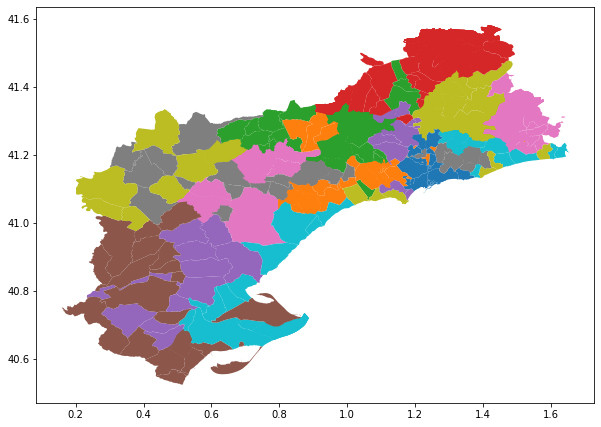

In [ ]:
gdf.plot(column = "COD_POSTAL", figsize=(10,10))

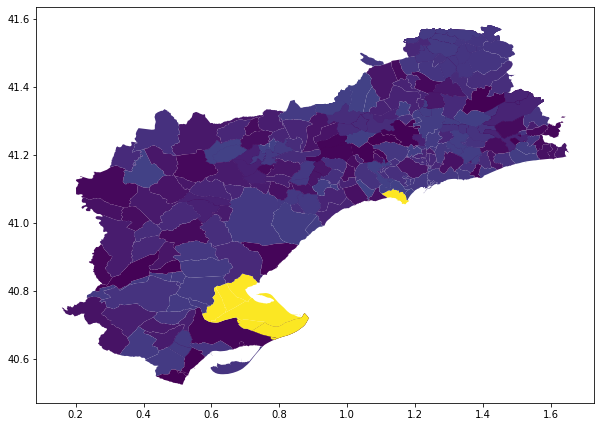

In [ ]:
gdf.plot(column = "COD_MUN", figsize=(10,10))

## 2. Some analysis of the data 

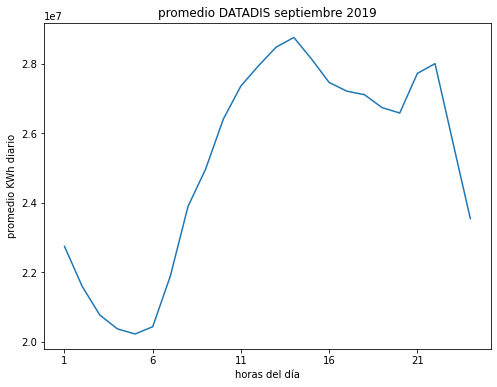

In [ ]:
# PLOTING THE MEAN OF A MONTH


import matplotlib.pyplot as plt

ax = pdData.mean(axis=1).plot(kind = 'line', figsize=(8,6),x='hora del día',y='KWh',title="promedio DATADIS septiembre 2019")
ax.set_xlabel("horas del día")
ax.set_ylabel("promedio KWh diario")
plt.show()

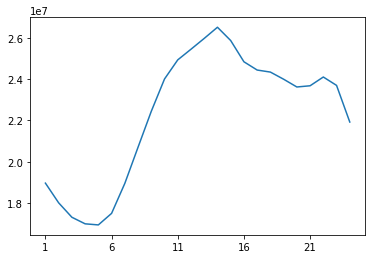

In [ ]:
dataPeninsula[:-1].plot()

## Comparison between DATADIS data and REE data

<font color='red'>**Los datos de REE son provisionales a partir de Junio 2020.**</font>

In [ ]:
# THE CLASS inputQueryClass TO DEFINE ATTRIBUTES IN THE SEARCH QUERY OBJECT LATER

# class inputREEClass(object):
#    def __init__(self):
#        self.startDate = None
#        self.endDate = None

In [ ]:
# DEFINING PARAMETERS TO PERFORM THE REE QUERY

# inputREE = inputREEClass()

# inputREE.startDate            = inputDateREE("01","06","2020") # startDate* 
# inputREE.endDate              = inputDateREE("02","06","2020") # endDate* 

In [ ]:
# A FUNCTION TO CODIFICATE DATE FORMATS VALID IN REE

# def inputDateREE(dia,mes,any):
#   return any+"-"+mes+"-"+dia

In [ ]:
# A FUNCTION TO CALCULATE AVERAGE FROM LIST OF INT

def average(lst):
    return sum(lst) / len(lst)

In [ ]:
# TO CALL THE API 

startTime='2020-09-01'
endTime = '2020-09-30'

urlData = "https://apidatos.ree.es/es/datos/demanda/demanda-tiempo-real?start_date="+startTime+"&end_date="+endTime+"&time_trunc=hour"+"&geo_limit=peninsular"
response = json.loads(urlopen(urlData).read())


In [ ]:
response

In [ ]:
response['included'][0]['attributes']['values'][0]

{'datetime': '2020-09-01T00:00:00.000+02:00',
 'percentage': 0.337238315075987,
 'value': 25275}

In [ ]:
# TO AGGREGATE DATA PER HOURS

_hour=[]
_cons=[]
for hour in range(0,24):
  _tmp = []
  for min in range(0,6):
    _tmp.append(response['included'][0]['attributes']['values'][6*hour+min]['value'])

  _mean = round(average(_tmp))*1000

  _hour.append(hour)
  _cons.append(_mean)

consZip = zip(_hour,_cons)
consDict = dict(consZip)

x,y = zip(*sorted(consDict.items()))


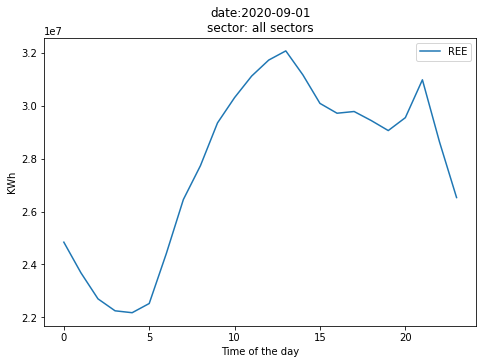

In [ ]:
# TO COMPARE DATA FROM DATADIS WITH DATA FROM REE

fig = plt.figure()
bx = fig.add_axes([0,0,1,1])
#bx.plot(dataPeninsula[:-1], label='DATADIS')
bx.plot(x,y, label="REE")
bx.set_ylabel('KWh')
bx.set_xlabel('Time of the day')
plt.title('date:'+startTime+'\nsector: all sectors')
plt.legend()
plt.show()

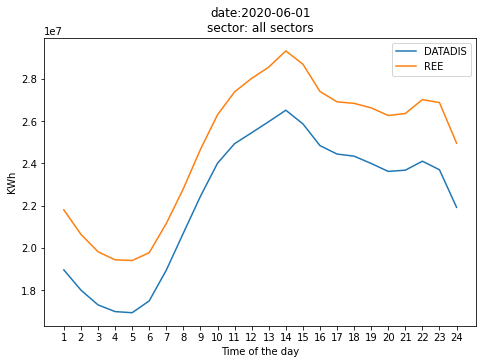

In [ ]:
# TO COMPARE DATA FROM DATADIS WITH DATA FROM REE

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(dataPeninsula[:-1], label='DATADIS')
ax.plot(x,y, label="REE")
ax.set_ylabel('KWh')
ax.set_xlabel('Time of the day')
plt.title('date:'+startTime+'\nsector: all sectors')
plt.legend()
plt.show()

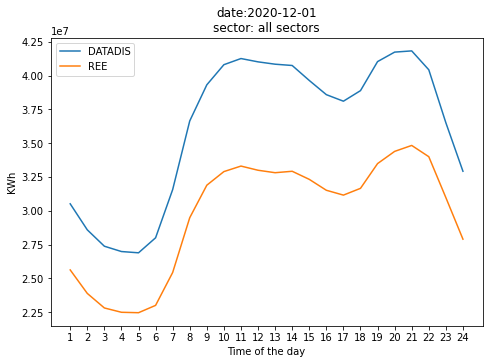

In [ ]:
# TO COMPARE DATA FROM DATADIS WITH DATA FROM REE

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(dataPeninsula[:-1], label='DATADIS')
ax.plot(x,y, label="REE")
ax.set_ylabel('KWh')
ax.set_xlabel('Time of the day')
plt.title('date:'+startTime+'\nsector: all sectors')
plt.legend()
plt.show()

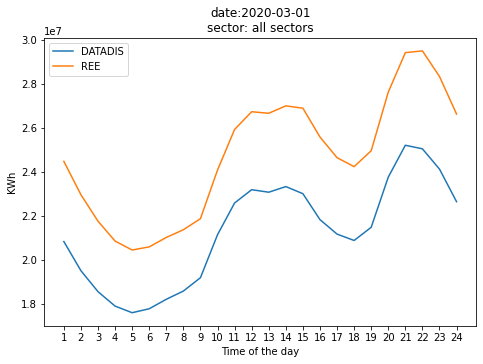

In [ ]:
# TO COMPARE DATA FROM DATADIS WITH DATA FROM REE

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(dataPeninsula[:-1], label='DATADIS')
ax.plot(x,y, label="REE")
ax.set_ylabel('KWh')
ax.set_xlabel('Time of the day')
plt.title('date:'+startTime+'\nsector: all sectors')
plt.legend()
plt.show()

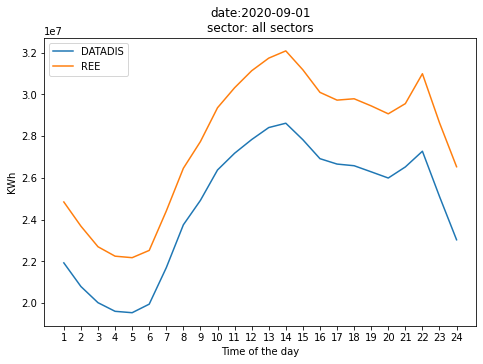

In [ ]:
# TO COMPARE DATA FROM DATADIS WITH DATA FROM REE

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(dataPeninsula[:-1], label='DATADIS')
ax.plot(x,y, label="REE")
ax.set_ylabel('KWh')
ax.set_xlabel('Time of the day')
plt.title('date:'+startTime+'\nsector: all sectors')
plt.legend()
plt.show()

A simple vista parece que la comparativa entre DATADIS y REE siempre deja a DATADIS un poco por debajo de los valores de REE

https://demanda.ree.es/visiona/baleares/baleares/total/2020-06-01

Esto puede ser debido a que DATADIS, tal y como se informa en la web, no incluye a todos los consumidores mientras que REE, a priori, sí.

Pero lo que sí sabemos es a cuántos usuarios se corresponden los datos que tenemos (sabemos el número de contratos). De ahí podemos obtener el promedio por contrato o el promedio por m² de vivienda, si utilizamos un valor promedio de superficie de vivienda como han hecho los de Lleida.

Task: Para ver si los datos de DATADIS están siempre el mismo % por debajo con respecto a REE, podemos calcular el % de diferencia por día para muchos días y ver si es estable.



---


## APPENDIX 

In [ ]:
# WORKING ON THE ANALYSIS 

# https://www.ree.es/es/datos/demanda/evolucion -> a partir de estos datos comparar unidades


# https://www.ree.es/sites/default/files/01_ACTIVIDADES/Documentos/Documentacion-Simel/ficheros_para_el_intercambio_de_informacion_de_medida_v32_marzo2019.pdf

# https://gesternova.com/energia-reactiva-en-la-factura-de-la-luz-de-tu-empresa-algunos-consejos-y-como-calcularla/

List of Regions in Spain and their codification in DATADIS 

    01 - Andalucía
    02 - Aragón
    03 - Principado de Asturias
    04 - Islas Baleares
    05 - Canarias
    06 - Cantabria
    07 - Castilla y León
    08 - Castilla La Mancha
    09 - Cataluña
    10 - Comunidad Valenciana

    11 - Extremadura
    12 - Galicia
    13 - Comunidad de Madrid
    14 - Región de Murcia
    15 - Comunidad Foral de Navarra
    16 - País Vasco
    17 - La Rioja
    18 - Ceuta
    19 - Melilla

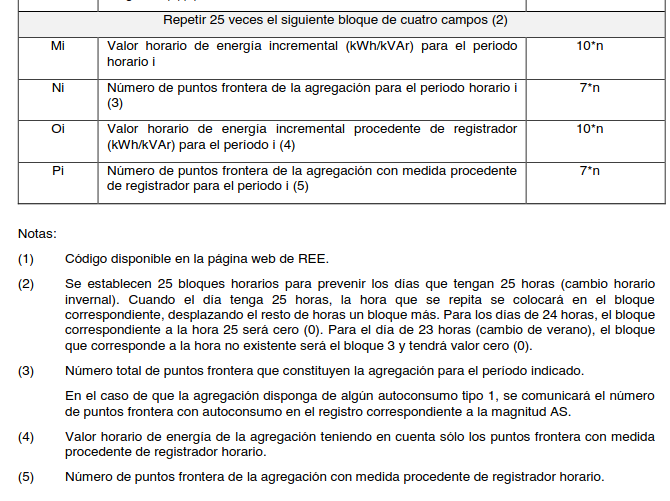